In [15]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Lectura de datos

In [16]:
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
air_passengers_df.columns = ["time", "value"]
air_passengers_df.head()


,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [17]:
## https://www.kaggle.com/datasets/bobnau/daily-website-visitors/code
daily_website_df = pd.read_csv("../kats/data/daily-website-visitors.csv")
daily_website_df.head()
# Function to remove commas
def remove_commas(x):
    return float(x.replace(',', ''))
# Apply the preprocessing functions

daily_website_df['Date'] = pd.to_datetime(daily_website_df['Date'])
daily_website_df['Page.Loads'] = daily_website_df['Page.Loads'].apply(lambda x : remove_commas(x))
daily_website_df['Unique.Visits'] = daily_website_df['Unique.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['First.Time.Visits'] = daily_website_df['First.Time.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['Returning.Visits'] = daily_website_df['Returning.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['Day.Of.Week']
df_mask=daily_website_df['Day.Of.Week']==2
daily_website_df_monday = daily_website_df[df_mask]


daily_website_df.drop(['Row','Day','Day.Of.Week','Returning.Visits'],inplace=True,axis=1)
daily_website_df.columns = ["time", "PageLoads","UniqueVisits", "FirstTimeVisits" ]

daily_website_df_monday.drop(['Row','Day','Day.Of.Week','Returning.Visits'],inplace=True,axis=1)
daily_website_df_monday.columns = ["time", "PageLoads","UniqueVisits", "FirstTimeVisits" ]



## First study

In [18]:
# air_passengers_df.shape
air_passengers_df.describe()
air_passengers_df.dtypes

time     object
value     int64
dtype: object

In [19]:

daily_website_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PageLoads,2167.0,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
UniqueVisits,2167.0,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
FirstTimeVisits,2167.0,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0


## First visualitation

In [20]:
air_passengers_ts = TimeSeriesData(air_passengers_df)
daily_website_ts = TimeSeriesData(daily_website_df)

daily_website_ts_monday = TimeSeriesData(daily_website_df_monday)

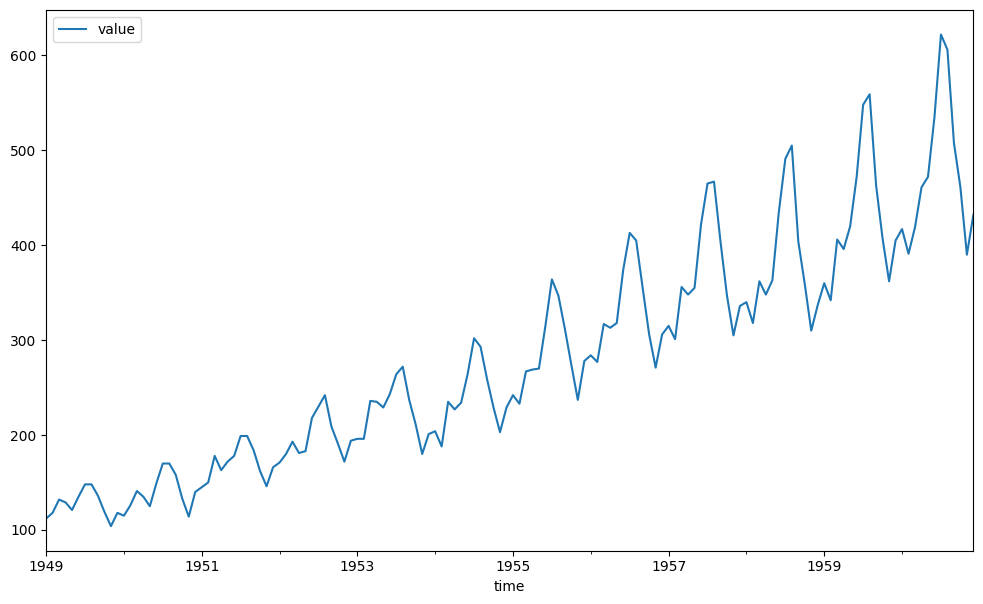

In [21]:
%matplotlib inline

# Must pass the name of the value columns to plot
air_passengers_ts.plot(cols=['value'])
plt.show()

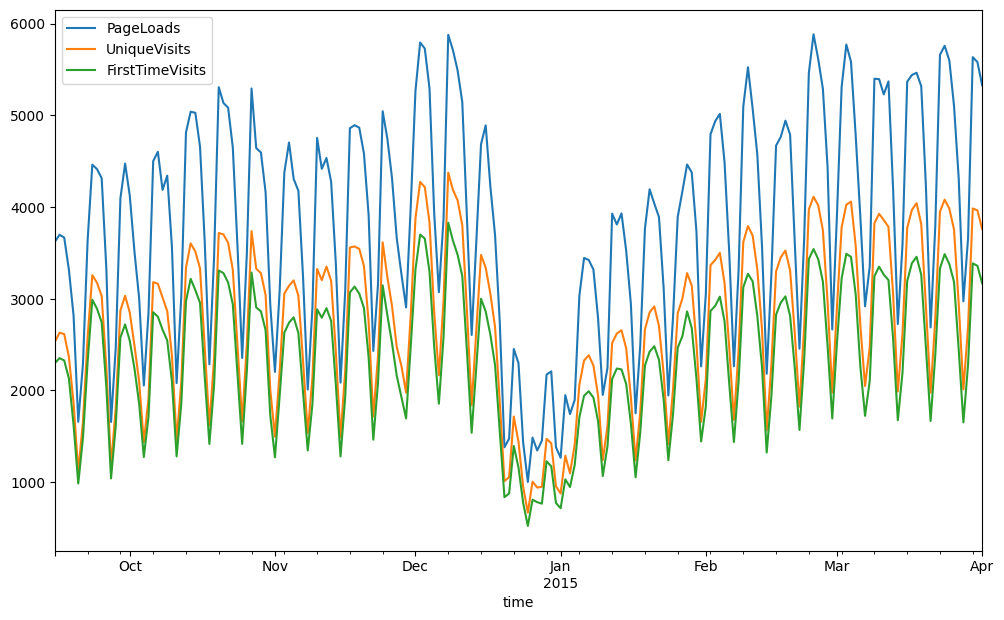

In [22]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts[1:200].plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
plt.show()

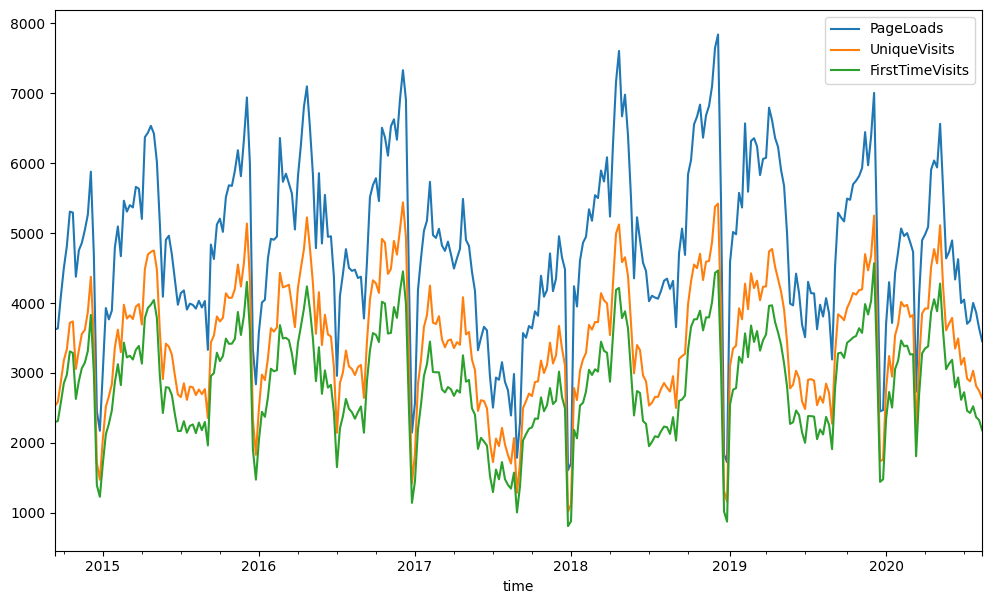

In [23]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts_monday.plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
plt.show()

# First comparative

## individual models

In [24]:
## HYPERPARAMETERS
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData


from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

### sarima

In [39]:
from kats.models.sarima import SARIMAModel, SARIMAParams
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
}
# {
#     "name": "seasonal_order",
#     "type": "choice",
#     "values": [(0,0,0,12),(1,1,1,12),(1,0,0,12),(0,1,0,12),(0,0,1,12),(1,1,0,12),(1,0,1,12),(0,1,1,12)],
#     "value_type": "int",
#     "is_ordered": True,
# },
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    sarima_params = SARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = SARIMAModel(train_ts, sarima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,85.254156,0.0,0,"{'p': 1, 'd': 1, 'q': 1}"
1,0_1,evaluation_metric,62.063473,0.0,0,"{'p': 1, 'd': 1, 'q': 2}"
2,0_2,evaluation_metric,126.992591,0.0,0,"{'p': 1, 'd': 2, 'q': 1}"
3,0_3,evaluation_metric,115.322728,0.0,0,"{'p': 1, 'd': 2, 'q': 2}"
4,0_4,evaluation_metric,60.528996,0.0,0,"{'p': 2, 'd': 1, 'q': 1}"
5,0_5,evaluation_metric,63.545311,0.0,0,"{'p': 2, 'd': 1, 'q': 2}"
6,0_6,evaluation_metric,102.744892,0.0,0,"{'p': 2, 'd': 2, 'q': 1}"
7,0_7,evaluation_metric,120.273295,0.0,0,"{'p': 2, 'd': 2, 'q': 2}"


<AxesSubplot: xlabel='time', ylabel='y'>

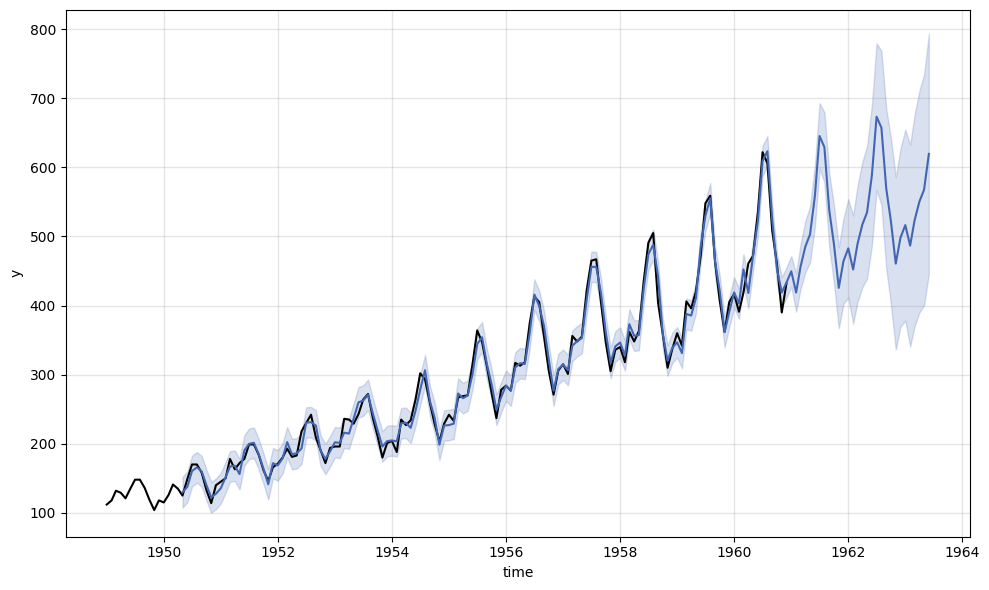

In [25]:
warnings.simplefilter(action='ignore')

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    trend = 'ct', #both linear or constant
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=air_passengers_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS",
    include_history=True
    )

# make plot to visualize
m.plot()

### arima

In [35]:
from kats.models.arima import ARIMAParams, ARIMAModel
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    arima_params = ARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = ARIMAModel(train_ts, arima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,115.202398,0.0,0,"{'p': 1, 'd': 1, 'q': 1}"
1,0_1,evaluation_metric,54.991706,0.0,0,"{'p': 1, 'd': 1, 'q': 2}"
2,0_2,evaluation_metric,183.296357,0.0,0,"{'p': 1, 'd': 2, 'q': 1}"
3,0_3,evaluation_metric,157.335281,0.0,0,"{'p': 1, 'd': 2, 'q': 2}"
4,0_4,evaluation_metric,52.022001,0.0,0,"{'p': 2, 'd': 1, 'q': 1}"
5,0_5,evaluation_metric,56.345822,0.0,0,"{'p': 2, 'd': 1, 'q': 2}"
6,0_6,evaluation_metric,141.107596,0.0,0,"{'p': 2, 'd': 2, 'q': 1}"
7,0_7,evaluation_metric,165.195943,0.0,0,"{'p': 2, 'd': 2, 'q': 2}"


<AxesSubplot: xlabel='time', ylabel='y'>

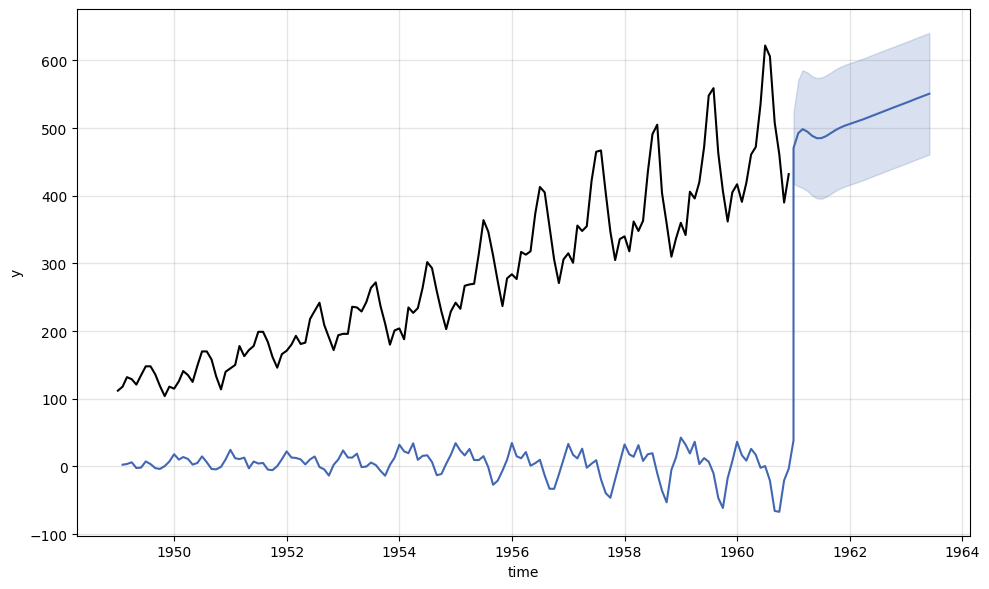

In [33]:
# create ARIMA param class
params = ARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    )

# initiate SARIMA model
m = ARIMAModel(data=air_passengers_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS",
    include_history=True
    )

# make plot to visualize
m.plot()

### prophet

In [46]:
# # import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams
warnings.simplefilter(action='ignore')


parameters_grid_search = [
{
    "name": "seasonality_mode",
    "type": "choice",
    "values": ['additive','multiplicative'],
    "value_type": "str",
    "is_ordered": True,
},
{
    "name": "n_changepoints",
    "type": "choice",
    "values": list(range(10, 30)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "changepoint_range",
    "type": "choice",
    "values": [0.6, 0.7, 0.8, 0.9],
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    prophet_params = ProphetParams(
        seasonality_mode= params['seasonality_mode'],
        n_changepoints= params['n_changepoints'],
        changepoint_range=  params['changepoint_range']
    )
    model = ProphetModel(train_ts, prophet_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using -1.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using -1.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using -1.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
1,0_1,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
2,0_2,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
3,0_3,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
4,0_4,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
5,0_5,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
6,0_6,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
7,0_7,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
8,0_8,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."
9,0_9,evaluation_metric,45.095257,0.0,0,"{'seasonality_mode': 'additive', 'n_changepoin..."


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot: xlabel='time', ylabel='y'>

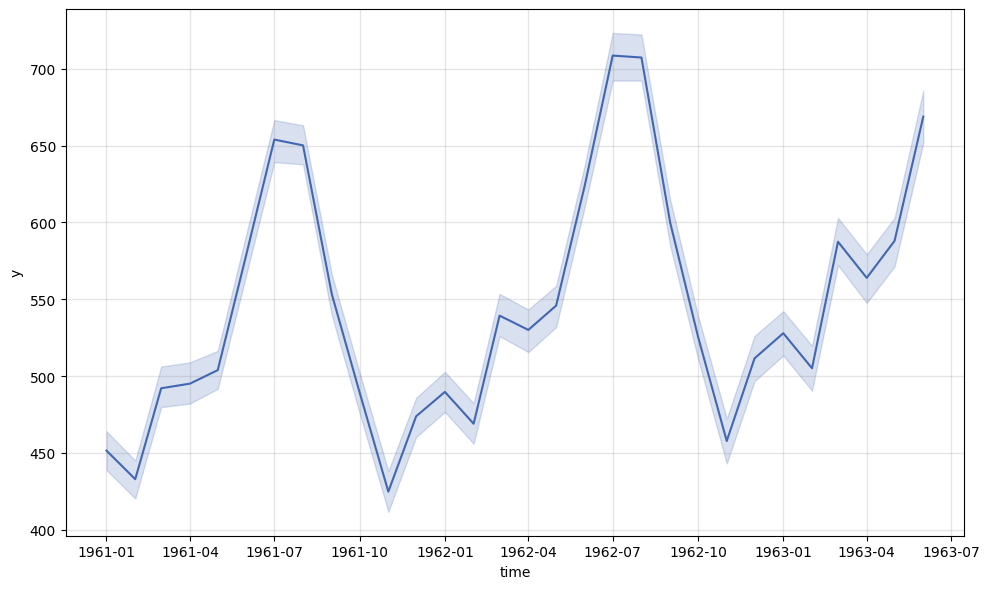

In [47]:
# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

# plot to visualize
m.plot()

### holt-winter

In [59]:
from kats.models.holtwinters import HoltWintersModel, HoltWintersParams
parameters_grid_search = [
{
    "name": "trend",
    "type": "choice",
    "values": ['additive','multiplicative'],
    "value_type": "str",
    "is_ordered": True,
},
{
    "name": "damped",
    "type": "choice",
    "values": [True, False],
    "value_type": "bool",
    "is_ordered": True,
},
{
    "name": "seasonal",
    "type": "choice",
    "values": ['additive','multiplicative'],
    "value_type": "str",
    "is_ordered": True,
},
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    holt_params = HoltWintersParams(
        trend= params['trend'],
        damped= params['damped'],
        seasonal = params['seasonal'],
        seasonal_periods =  12
    )
    model = HoltWintersModel(train_ts, holt_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid#.parameters[4]

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,evaluation_metric,31.787854,0.0,0,"{'trend': 'additive', 'damped': False, 'season..."
1,0_1,evaluation_metric,21.952954,0.0,0,"{'trend': 'additive', 'damped': False, 'season..."
2,0_2,evaluation_metric,44.737383,0.0,0,"{'trend': 'additive', 'damped': True, 'seasona..."
3,0_3,evaluation_metric,41.480205,0.0,0,"{'trend': 'additive', 'damped': True, 'seasona..."
4,0_4,evaluation_metric,12.879526,0.0,0,"{'trend': 'multiplicative', 'damped': False, '..."
5,0_5,evaluation_metric,17.470693,0.0,0,"{'trend': 'multiplicative', 'damped': False, '..."
6,0_6,evaluation_metric,50.871837,0.0,0,"{'trend': 'multiplicative', 'damped': True, 's..."
7,0_7,evaluation_metric,19.489781,0.0,0,"{'trend': 'multiplicative', 'damped': True, 's..."


<AxesSubplot: xlabel='time', ylabel='y'>

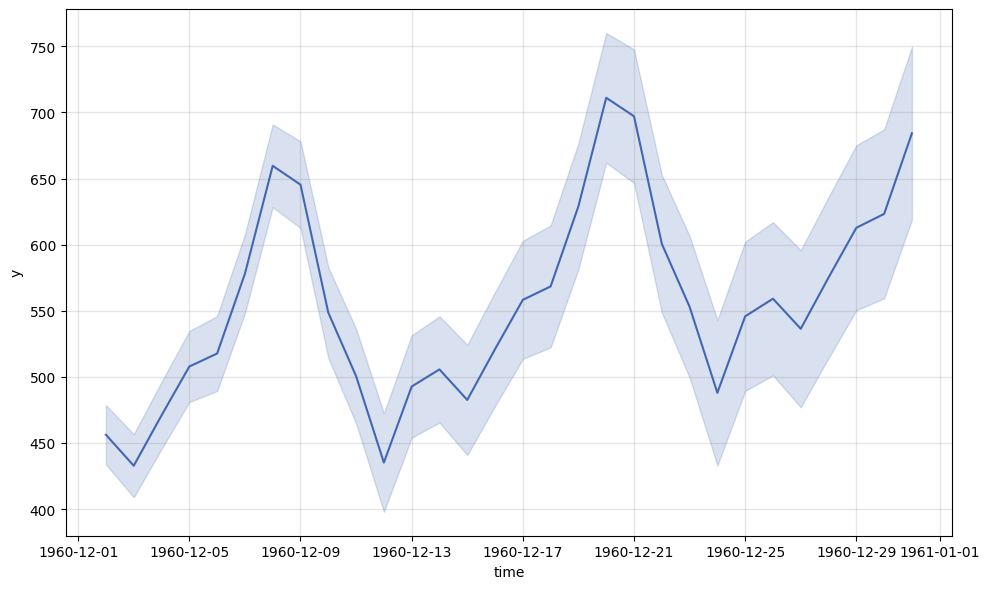

In [58]:
warnings.simplefilter(action='ignore')


params = HoltWintersParams(
            trend="mul",
            damped=False,
            seasonal="add",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=air_passengers_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### lstm

In [72]:
from kats.models.lstm import LSTMParams, LSTMModel

parameters_grid_search = [
{
    "name": "hidden_size",
    "type": "choice",
    "values": list(range(1,5)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "time_window",
    "type": "choice",
    "values": list(range(1,5)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "num_epochs",
    "type": "choice",
    "values": list(range(1,5)),
    "value_type": "int",
    "is_ordered": True,
},
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    lstm_params = LSTMParams(
        hidden_size= params['hidden_size'],
        time_window= params['time_window'],
        num_epochs = params['num_epochs']
    )
    model = LSTMModel(train_ts, lstm_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)



In [73]:
min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'hidden_size': 1, 'time_window': 3, 'num_epochs': 2}

<AxesSubplot: xlabel='time', ylabel='y'>

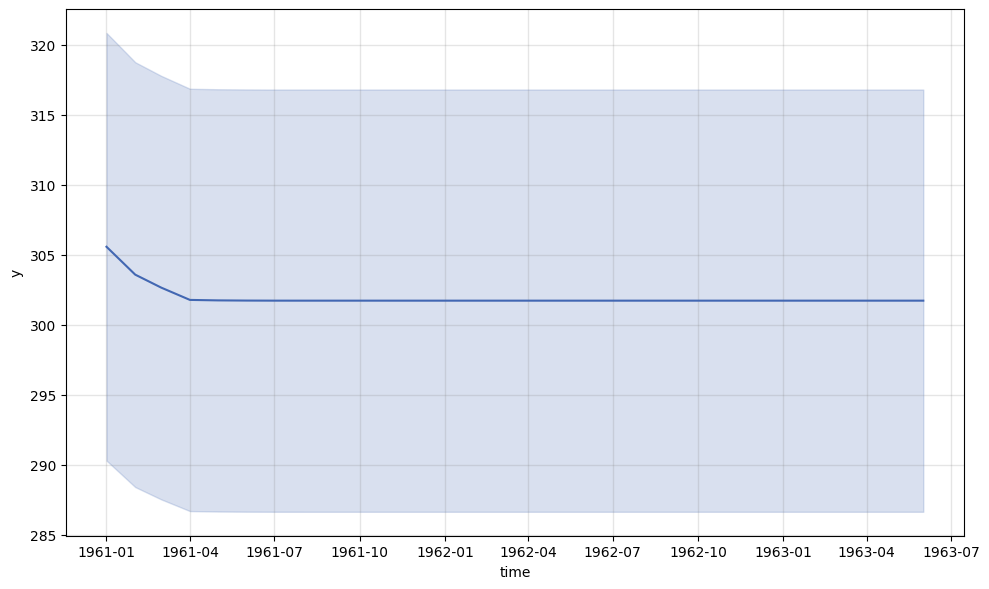

In [74]:
warnings.simplefilter(action='ignore')

params = LSTMParams(
            hidden_size=1,
            time_window=3,
            num_epochs=2
        )
m = LSTMModel(
    data=air_passengers_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

### thetha

<AxesSubplot: xlabel='time', ylabel='y'>

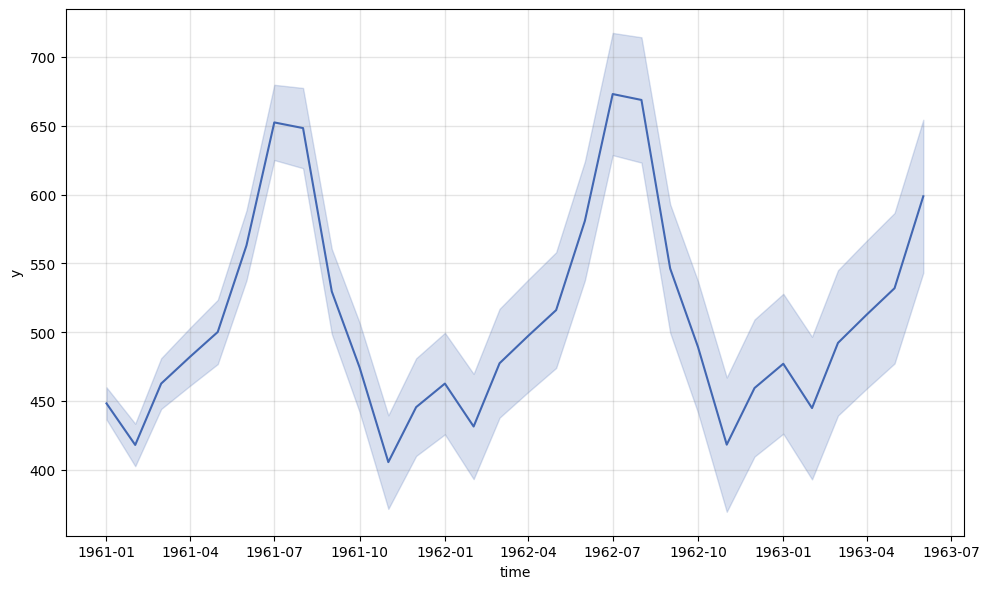

In [75]:
# No es necesario hacer un grid, sabemos que la estacionalidad es 12
from kats.models.theta import ThetaModel, ThetaParams
warnings.simplefilter(action='ignore')

params = ThetaParams(
            m = 12
        )
m = ThetaModel(
    data=air_passengers_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()